# Path Finding with Z3
This notebook demonstrates using a solver like Z3 to do path finding. It is not the most efficient way to solve a maze but traditional algorithms such as Djikstra's and A* are challenging to adapt to variants such as multi-agent path finding.

In [1]:
import xml.etree.ElementTree as ET
from dataclasses import dataclass

# 3rd party dependencies
from IPython.display import SVG, display
import z3

First, we define some useful geometric types and a helper generator to iterate over the barriers of the grid

In [2]:
@dataclass
class Dimension:
    width: int
    height: int
    
    def __mul__(self, other):
        return Dimension(self.width * other.width, self.height * other.height)
    
    def __add__(self, other):
        return Dimension(self.width + other.width, self.height + other.height)


@dataclass
class Point:
    x: int
    y: int
        
    def __repr__(self):
        return '('+str(self.x)+', '+str(self.y)+')'
    
    def scale(self, mult: Dimension, plus=Dimension(0, 0)):
        return Point(
            self.x * mult.width + plus.width,
            self.y * mult.height + plus.height
        )


def each_barrier(grid):
    grid_dim = Dimension(len(grid[0]), len(grid))
    for y in range(grid_dim.height):
        for x in range(grid_dim.width):
            if grid[y][x] > 0:
                yield Point(x, y)

We will be displaying our solution by constructing the image in SVG using the builtin python module etree.
* draw a dashed grid over the grid domain
* draw solution rects in yellow
* draw barrier rects in gray

In [3]:
def draw_solution(grid, node_pos):
    # graphical dimension constants
    grid_dim = Dimension(len(grid[0]), len(grid))
    margin_dim = Dimension(3, 3)
    node_dim = Dimension(30, 30)
    stroke_size = Dimension(1, 1)
    svg_dims = grid_dim * node_dim + margin_dim + stroke_size
    
    svg = ET.Element(
        'svg',
        xmlns="http://www.w3.org/2000/svg",
        version="1.1",
        height=str(svg_dims.height),
        width=str(svg_dims.width))
    style = ET.SubElement(
        svg,
        "style")
    style.text ="rect {fill: gray; stroke: black;} line {stroke: black}"
    
    # draw dashed gray grid
    for x in range(grid_dim.width + 1):
        p = Point(x, 0).scale(node_dim, margin_dim)
        l = ET.SubElement(
            svg,
            'line',
            x1=str(p.x),
            x2=str(p.x),
            y1="5",
            y2=str(svg_dims.height))
        l.set('stroke-dasharray', '4 8')
    for y in range(grid_dim.height + 1):
        p = Point(0, y).scale(node_dim, margin_dim)
        l = ET.SubElement(
            svg,
            'line',
            x1="5",
            x2=str(svg_dims.width),
            y1=str(p.y),
            y2=str(p.y))
        l.set('stroke-dasharray', '4 8')
    # draw solution path in yellow
    for node in node_pos:
        p = node.scale(node_dim, margin_dim)
        ET.SubElement(
            svg,
            'rect',
            x=str(p.x),
            y=str(p.y),
            width=str(node_dim.width),
            height=str(node_dim.height),
            style="fill:yellow")
    # draw barriers in gray
    for barrier in each_barrier(grid):
        p = barrier.scale(node_dim, margin_dim)
        ET.SubElement(
            svg,
            'rect',
            x=str(p.x),
            y=str(p.y),
            width=str(node_dim.width),
            height=str(node_dim.height))
    display(SVG(ET.tostring(svg)))

We define a point class for z3 variables and define some useful operators.

In [4]:
def zabs(x):
    return z3.If(x >= 0, x, -x)


class ZPoint:
    def __init__(self, prefix):
        self.x, self.y = z3.Ints(prefix+'.x '+prefix+'.y')
    
    def __repr__(self):
        return '('+str(self.x)+', '+str(self.y)+')'
    
    def __eq__(self, other):
        return z3.And(self.x == other.x, self.y == other.y)
    
    def __ne__(self, other):
        return z3.Or(self.x != other.x, self.y != other.y)
    
    def distance_from(self, other):
        return zabs(self.x - other.x) + zabs(self.y - other.y)
    
    def within(self, d : Dimension):
        return z3.And(
            self.x > -1,
            self.x < d.width,
            self.y > -1,
            self.y < d.height)

We will be formulating our path as a sequence of t_max positions where t_max is the maximum number of steps to the destination.

* The first position must be in the top left corner
* The last position must be in the bottom right corner
* All positions must be on the grid
* All positions can be no more than one step away from the previous position
* No position may be on a barrier
* score a point for each position on the destination

Find the maximum score.

In [12]:
import time
def solve_maze(grid, t_max):
    grid_dim = Dimension(len(grid[0]), len(grid))
    # construct ZPoints
    zt = [ZPoint('z[%d]' % t) for t in range(t_max)]

    solver = z3.Optimize()
    score = []
    
    source = Point(0, 0)
    destination = Point(grid_dim.width - 1, grid_dim.height - 1)
    # the first point must be on the source
    solver.add(zt[0] == source)
    # the last point must be on the destination
    solver.add(zt[-1] == destination)

    for t in range(t_max):
        pos = zt[t]
        # all points must be on the grid
        solver.add(pos.within(grid_dim))
        if t > 0:
            prev = zt[t - 1]
            # points can be no more than one step away from previous
            solver.add(pos.distance_from(prev) <= 1)
        # points cannot be on barriers
        for barrier in each_barrier(grid):
            solver.add(pos != barrier)
        # score a point for each pos at the destination
        score.append(z3.If(pos == destination, 100, 0))
    
    start_time = time.time()
    solver.maximize(z3.Sum(score))
    if solver.check() != z3.sat:
        print('unsolved time:', time.time() - start_time)
        print('either this maze has no solution or t_max isnt large enough')
        raise Exception('no bueno')
    
    
    solution = solver.model()
    print('solve time:', time.time() - start_time)
    solution_dict = {str(s): solution[s].as_long() for s in solution}
    node_pos = []
    for t in range(t_max):
        node_pos.append(Point(
            solution_dict['z[%d].x' % t],
            solution_dict['z[%d].y' % t]))
    return node_pos

solve time: 0.005525827407836914


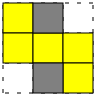

[(0, 0), (0, 1), (1, 1), (2, 1), (2, 2)]

In [13]:
grid = [[0,1,0],
        [0,0,0],
        [0,1,0]]
solution = solve_maze(grid, 5)
draw_solution(grid, solution)
solution

solve time: 3.2236502170562744


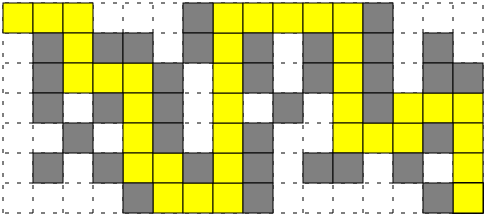

In [14]:
t_max = 40
grid = [[0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0],
        [0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0],
        [0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,1],
        [0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0],
        [0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0],
        [0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0],
        [0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0]]
solution = solve_maze(grid, t_max)
draw_solution(grid, solution)